In [17]:
import pandas as pd
import math
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt

class dataLoader:
    def __init__(self, data_url, label):
        warnings.filterwarnings('ignore')
        pd.options.mode.chained_assignment = None
        
        if data_url.endswith('.csv'):
            self.data = pd.read_csv(data_url)
        elif data_url.endswith('.xlsx'):
            self.data = pd.read_excel(data_url)
        else:
            raise ValueError("Unsupported file format. Please provide a CSV or XLSX file.")
        
        self.label = label
        
        if self.label not in self.data.columns.tolist():
            raise Exception("label not in dataset")
        
    def detachedData(self, data):
        Y = data[self.label]
        X = data.drop(columns=[self.label])
        return X, Y

    def hold_out(self, train_per=0.7, val_per=0.3):             
        self.train_data = self.data.iloc[0:math.floor(train_per * len(self.data))]
        self.val_data = self.data.iloc[len(self.train_data):]
        
        self.train_data.X, self.train_data.Y = self.detachedData(self.train_data)
        self.val_data.X, self.val_data.Y = self.detachedData(self.val_data)
        
    def kfold_split(self, K, shuffle=True, random_state=42):
        if shuffle:          
            indices = list(self.data.index)
            random.seed(random_state)
            random.shuffle(indices)
            self.data = self.data.iloc[indices].reset_index(drop=True)

        fold_sizes = np.full(K, len(self.data) // K, dtype=int)
        fold_sizes[: len(self.data) % K] += 1

        current = 0
        folds = []
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            folds.append(self.data.iloc[start:stop])
            current = stop

        return folds
    
    def K_fold(self, K=5):
        folds = self.kfold_split(K, shuffle=True)
        self.val_data = []
        self.train_data = []

        for i in range(K):
            self.val_data.append(folds[i])

            train_j = pd.DataFrame()
            for j in range(K):
                if i != j:
                    train_j = pd.concat([train_j, folds[j]], axis=0, ignore_index=True)
            self.train_data.append(train_j)

        for i in range(len(self.train_data)):
            self.train_data[i].X, self.train_data[i].Y = self.detachedData(self.train_data[i])
            self.val_data[i].X, self.val_data[i].Y = self.detachedData(self.val_data[i])
            
    def LOO(self):
        self.K_fold(len(self.data))

In [18]:
class Evaluate:
    @staticmethod
    def loss(y_true, y_pred):
        return abs(y_true - y_pred) / len(y_true)
    
    @staticmethod
    def confusion_matrix(y_true, y_pred):
        unique_labels = np.unique(y_true)
        matrix = {label: {l: 0 for l in unique_labels} for label in unique_labels}

        for true, pred in zip(y_true, y_pred):
            matrix[true][pred] += 1

        return matrix

    @staticmethod
    def classification_report(y_true, y_pred):
        cm = Evaluate.confusion_matrix(y_true, y_pred)
        report = {}
        
        for label in cm:
            TP = cm[label][label]
            FP = sum(cm[l][label] for l in cm if l != label)
            FN = sum(cm[label][l] for l in cm if l != label)
            TN = sum(cm[l][k] for l in cm for k in cm[l] if l != label and k != label)
            
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
            tpr = recall
            
            report[label] = {
                'precision': precision,
                'recall': recall,
                'f1_score': f1_score,
                'fpr': fpr,
                'tpr': tpr
            }

        return report

    @staticmethod
    def plot_roc_curve(y_true, y_pred_proba):
        thresholds = np.linspace(0, 1, 101)
        tpr = []
        fpr = []

        for threshold in thresholds:
            y_pred = (y_pred_proba >= threshold).astype(int)
            TP = np.sum((y_true == 1) & (y_pred == 1))
            FP = np.sum((y_true == 0) & (y_pred == 1))
            TN = np.sum((y_true == 0) & (y_pred == 0))
            FN = np.sum((y_true == 1) & (y_pred == 0))

            tpr_value = TP / (TP + FN) if (TP + FN) > 0 else 0
            fpr_value = FP / (FP + TN) if (FP + TN) > 0 else 0

            tpr.append(tpr_value)
            fpr.append(fpr_value)

        tpr = np.array(tpr)
        fpr = np.array(fpr)

        auc_value = np.trapz(tpr, fpr)

        # Debugging information
        print("Thresholds:", thresholds)
        print("TPR values:", tpr)
        print("FPR values:", fpr)
        print("AUC value:", auc_value)

        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_value)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

In [19]:
#Hold_out
data_url = dataLoader('/kaggle/input/team2-dataset/team2_dataset/chap5.xlsx','Sales')

data_url.hold_out()

print(f'Dataset ban đầu:\n{data_url.data}')
print(f'\nTập Train: \n{data_url.train_data}\nTập Val: \n{data_url.val_data}')

print(f'\nBiến độc lập tập Train: \n{data_url.train_data.X}\nBiến phụ thuộc tập Train: \n{data_url.train_data.Y}')

print(f'\nBiến độc lập tập Val: \n{data_url.val_data.X}\nbiến phụ thuộc tập Val: \n{data_url.val_data.Y}')


Dataset ban đầu:
        TV  Radio  Newspaper  Sales
0    230.1   37.8       69.2   22.1
1     44.5   39.3       45.1   10.4
2     17.2   45.9       69.3    9.3
3    151.5   41.3       58.5   18.5
4    180.8   10.8       58.4   12.9
..     ...    ...        ...    ...
195   38.2    3.7       13.8    7.6
196   94.2    4.9        8.1    9.7
197  177.0    9.3        6.4   12.8
198  283.6   42.0       66.2   25.5
199  232.1    8.6        8.7   13.4

[200 rows x 4 columns]

Tập Train: 
        TV  Radio  Newspaper  Sales
0    230.1   37.8       69.2   22.1
1     44.5   39.3       45.1   10.4
2     17.2   45.9       69.3    9.3
3    151.5   41.3       58.5   18.5
4    180.8   10.8       58.4   12.9
..     ...    ...        ...    ...
135   48.3   47.0        8.5   11.6
136   25.6   39.0        9.3    9.5
137  273.7   28.9       59.7   20.8
138   43.0   25.9       20.5    9.6
139  184.9   43.9        1.7   20.7

[140 rows x 4 columns]
Tập Val: 
        TV  Radio  Newspaper  Sales
140   73.4  

In [20]:
# K_fold
data_url = dataLoader('/kaggle/input/team2-dataset/team2_dataset/chap5.xlsx','Sales')

data_url.K_fold()

print(f'Dataset ban đầu:\n{data_url.data}')
print(f'\nTập Train: \n{data_url.train_data[0]}\nTập Val: \n{data_url.val_data[0]}')

print(f'\nBiến độc lập tập Train: \n{data_url.train_data[0].X}\nBiến phụ thuộc tập Train: \n{data_url.train_data[0].Y}')

print(f'\nBiến độc lập tập Val: \n{data_url.val_data[0].X}\nbiến phụ thuộc tập Val: \n{data_url.val_data[0].Y}')

Dataset ban đầu:
        TV  Radio  Newspaper  Sales
0     31.5   24.6        2.2    9.5
1    191.1   28.7       18.2   17.3
2    296.4   36.3      100.9   23.8
3    166.8   42.0        3.6   19.6
4    241.7   38.0       23.2   21.8
..     ...    ...        ...    ...
195  199.1   30.6       38.7   18.3
196   18.7   12.1       23.4    6.7
197   57.5   32.8       23.5   11.8
198  248.8   27.1       22.9   18.9
199  163.5   36.8        7.4   18.0

[200 rows x 4 columns]

Tập Train: 
        TV  Radio  Newspaper  Sales
0    164.5   20.9       47.4   14.5
1     53.5    2.0       21.4    8.1
2     66.1    5.8       24.2    8.6
3     96.2   14.8       38.9   11.4
4    172.5   18.1       30.7   14.4
..     ...    ...        ...    ...
155  199.1   30.6       38.7   18.3
156   18.7   12.1       23.4    6.7
157   57.5   32.8       23.5   11.8
158  248.8   27.1       22.9   18.9
159  163.5   36.8        7.4   18.0

[160 rows x 4 columns]
Tập Val: 
       TV  Radio  Newspaper  Sales
0    31.5   2

In [21]:
#Leave one out
data_url = dataLoader('/kaggle/input/team2-dataset/team2_dataset/chap5.xlsx','Sales')

data_url.LOO()

print(f'Dataset ban đầu:\n{data_url.data}')
print(f'\nTập Train: \n{data_url.train_data[0]}\nTập Val: \n{data_url.val_data[0]}')

print(f'\nBiến độc lập tập Train: \n{data_url.train_data[0].X}\nBiến phụ thuộc tập Train: \n{data_url.train_data[0].Y}')

print(f'\nBiến độc lập tập Val: \n{data_url.val_data[0].X}\nbiến phụ thuộc tập Val: \n{data_url.val_data[0].Y}')

Dataset ban đầu:
        TV  Radio  Newspaper  Sales
0     31.5   24.6        2.2    9.5
1    191.1   28.7       18.2   17.3
2    296.4   36.3      100.9   23.8
3    166.8   42.0        3.6   19.6
4    241.7   38.0       23.2   21.8
..     ...    ...        ...    ...
195  199.1   30.6       38.7   18.3
196   18.7   12.1       23.4    6.7
197   57.5   32.8       23.5   11.8
198  248.8   27.1       22.9   18.9
199  163.5   36.8        7.4   18.0

[200 rows x 4 columns]

Tập Train: 
        TV  Radio  Newspaper  Sales
0    191.1   28.7       18.2   17.3
1    296.4   36.3      100.9   23.8
2    166.8   42.0        3.6   19.6
3    241.7   38.0       23.2   21.8
4     18.8   21.7       50.4    7.0
..     ...    ...        ...    ...
194  199.1   30.6       38.7   18.3
195   18.7   12.1       23.4    6.7
196   57.5   32.8       23.5   11.8
197  248.8   27.1       22.9   18.9
198  163.5   36.8        7.4   18.0

[199 rows x 4 columns]
Tập Val: 
     TV  Radio  Newspaper  Sales
0  31.5   24.6 

In [22]:
#ROC
class Linear_Regression:
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def fit(self):
        X = np.hstack((np.ones((self.X.shape[0], 1)), self.X))
        XT = X.T
        XTX = np.dot(XT, X)
        inv_XTX = np.linalg.inv(XTX)
        inv_XTX_XT = np.dot(inv_XTX, XT)
        beta = np.dot(inv_XTX_XT, self.Y)
        self.intercept = beta[0]
        self.coef = beta[1::]
            
    def predict(self, X_val):
        return np.dot(X_val, self.coef) + self.intercept

In [23]:
class Logistic_Regression:
    def __init__(self, X_train, Y_train):
        self.X = X_train
        self.Y = Y_train
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def fit(self):
        self.linear = Linear_Regression(self.X, self.Y)
        self.linear.fit()
        
    def predict(self, X_test):
        y = self.linear.predict(X_test)
        P = self.sigmoid(y)
        return np.where(P > 0.5, 1, 0), P

Hệ số: [0.0132043  0.00633224 0.03466563]
Số chặn b: -0.958414912098714

<class 'pandas.core.frame.DataFrame'>
   Y_actual  Y_predict
0         0          1
1         1          1
2         0          1
3         0          1
4         0          1
5         1          1
6         0          0
7         1          1
8         0          1
9         1          1
Thresholds: [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]
TPR values: [1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1. 

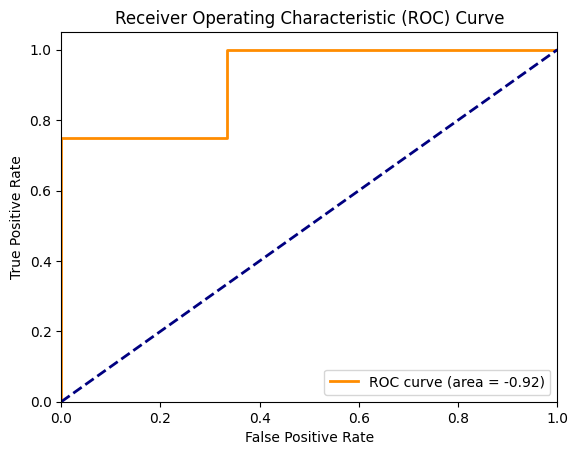

In [24]:
# Load and process the data
df = dataLoader('/kaggle/input/team2-dataset/team2_dataset/chap6.xlsx', 'Response')
X, Y = df.detachedData(df.data)

# Initialize and fit the logistic regression model
log_reg = Logistic_Regression(X, Y)
log_reg.fit()
print(f'Hệ số: {log_reg.linear.coef}\nSố chặn b: {log_reg.linear.intercept}\n')

# Predict the values and evaluate the model
Y_pred, Y_pred_proba = log_reg.predict(X)
Y_actual = Y.values  # Use .values to get the numpy array
data_rs2show = {'Y_actual': Y_actual, 'Y_predict': Y_pred}

rs2show = pd.DataFrame(data_rs2show)
print(type(rs2show))
print(rs2show)

# Plot ROC curve
Evaluate.plot_roc_curve(Y_actual, Y_pred_proba)